# Find Dishonest Restaurant
<img src="https://www.netclipart.com/pp/m/349-3494556_forex-scams-by-dishonest-person-lying-cartoon.png" width="600px">

## Description

Sometimes, some dishonest restaurants cheating TripAdvisor and their guests by winding up the rating higher than it should be.

The main aim of the project is to try to predict the rating of the restaurant with given data.

In case if the predictions of our model have significant differences from the actual result, then, most likely we found a dishonest restaurant. 

### Column Defination

Restaurant_id — restaurant / restaurant chain identification number;

City — In what city it is located;

Cuisine Style — related to a restaurant cuisine;

Ranking — the place that this restaurant occupies among all restaurants in its city;

Rating — restaurant rating according to TripAdvisor (Target Variable);

Price Range — restaurant price range;

Number of Reviews — Number of Reviews ;

Reviews — data about two reviews that are displayed on the restaurant's website;

URL_TA — URL on TripAdvisor;

ID_TA — Identificator of restaurant in TripAdvisor's DataBase.


---
### Import Libraries
---

In [1]:
from jupyterthemes import jtplot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from datetime import timedelta, datetime
from textblob import TextBlob  # for sentiment analysis
from wordcloud import WordCloud  # for creating cloud of words

import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import nltk
nltk.download('punkt')

warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

%matplotlib inline

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


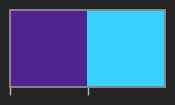

In [2]:
# colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff']
colors = ['#50248f', '#38d1ff']
sns.palplot(sns.color_palette(colors))

### 1.  Read and Chek the Dataset

In [3]:
df = pd.read_csv('main_task.csv')
print(f'Dataset shape: {df.shape}')

Dataset shape: (40000, 10)


### 1.1 Show basic info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df.describe()

Ranking        Rating  Number of Reviews
count  40000.000000  40000.000000       37457.000000
mean    3676.028525      3.993037         124.825480
std     3708.749567      0.668417         295.666352
min        1.000000      1.000000           2.000000
25%      973.000000      3.500000           9.000000
50%     2285.000000      4.000000          33.000000
75%     5260.000000      4.500000         115.000000
max    16444.000000      5.000000        9660.000000

### 1.2 Show the data types

In [6]:
df.dtypes

Restaurant_id         object
City                  object
Cuisine Style         object
Ranking              float64
Rating               float64
Price Range           object
Number of Reviews    float64
Reviews               object
URL_TA                object
ID_TA                 object
dtype: object

Let's see what type of data in each column-cell

In [7]:
for col in df.columns.values:
    print(col, type(df.loc[0, col]))

Restaurant_id <class 'str'>
City <class 'str'>
Cuisine Style <class 'str'>
Ranking <class 'numpy.float64'>
Rating <class 'numpy.float64'>
Price Range <class 'str'>
Number of Reviews <class 'numpy.float64'>
Reviews <class 'str'>
URL_TA <class 'str'>
ID_TA <class 'str'>


Well, it is more interesting. Let's briefly see at the content of object data.

In [8]:
obj_cols = df.select_dtypes(include=['object'])
obj_cols.head()

Restaurant_id       City                                      Cuisine Style  \
0       id_5569      Paris            ['European', 'French', 'International']   
1       id_1535  Stockholm                                                NaN   
2        id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3       id_3456     Berlin                                                NaN   
4        id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

  Price Range                                            Reviews  \
0    $$ - $$$  [['Good food at your doorstep', 'A good hotel ...   
1         NaN  [['Unique cuisine', 'Delicious Nepalese food']...   
2        $$$$  [['Catch up with friends', 'Not exceptional'],...   
3         NaN                                           [[], []]   
4    $$ - $$$  [['Best place to try a Bavarian food', 'Nice b...   

                                              URL_TA     ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...  d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...  d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...  d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...  d6864963

In [9]:
for i in obj_cols.iloc[0]:
    print(i)

id_5569
Paris
['European', 'French', 'International']
$$ - $$$
[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]
/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html
d1912643


As we can see we have some categorical data and text data here

Rename columns removing spaces and substituting capital letters

In [10]:
df.rename(columns={'Restaurant_id': 'restaurant_id',
                   'City': 'city',
                   'Cuisine Style': 'cuisine_style',
                   'Ranking': 'ranking',
                   'Rating': 'rating',
                   'Price Range': 'price_range',
                   'Number of Reviews': 'reviews_number',
                   'Reviews': 'reviews',
                   'URL_TA': 'url_ta',
                   'ID_TA': 'id_ta'}, inplace=True)
# show the data
df.head(1)

restaurant_id   city                            cuisine_style  ranking  \
0       id_5569  Paris  ['European', 'French', 'International']   5570.0   

   rating price_range  reviews_number  \
0     3.5    $$ - $$$           194.0   

                                             reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   

                                              url_ta     id_ta  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643

### 1.3 Missing values

Let's observe an empty data

In [11]:
missing = df[df.apply(lambda row: any(row == '') | any(row.isna()), axis=1)]
missing

restaurant_id        city               cuisine_style  ranking  rating  \
1           id_1535   Stockholm                         NaN   1537.0     4.0   
3           id_3456      Berlin                         NaN   3458.0     5.0   
5           id_1418      Oporto                         NaN   1419.0     3.0   
7            id_825  Bratislava                 ['Italian']    826.0     3.0   
8           id_2690      Vienna                         NaN   2692.0     4.0   
...             ...         ...                         ...      ...     ...   
39988       id_4968      Berlin                         NaN   4970.0     4.0   
39989       id_8887      London           ['International']   8896.0     5.0   
39990       id_1187      Oporto  ['European', 'Portuguese']   1188.0     4.5   
39993       id_6057       Paris                         NaN   6058.0     4.0   
39997       id_1649   Stockholm       ['Japanese', 'Sushi']   1652.0     4.5   

      price_range  reviews_number  \
1             NaN            10.0   
3             NaN             3.0   
5             NaN             2.0   
7             NaN             9.0   
8             NaN             NaN   
...           ...             ...   
39988         NaN             NaN   
39989         NaN             NaN   
39990         NaN            14.0   
39993         NaN            16.0   
39997         NaN             4.0   

                                                 reviews  \
1      [['Unique cuisine', 'Delicious Nepalese food']...   
3                                               [[], []]   
5      [['There are better 3 star hotel bars', 'Amazi...   
7      [['Wasting of money', 'excellent cuisine'], ['...   
8                                               [[], []]   
...                                                  ...   
39988                                           [[], []]   
39989           [['I love this place!'], ['08/24/2015']]   
39990  [['Traditional "home cooked" food for an "eco....   
39993  [['Naught but VERY nice', 'Yum'], ['01/23/2017...   
39997  [['Good by swedish standards', 'A hidden jewel...   

                                                  url_ta      id_ta  
1      /Restaurant_Review-g189852-d7992032-Reviews-Bu...   d7992032  
3      /Restaurant_Review-g187323-d1358776-Reviews-Es...   d1358776  
5      /Restaurant_Review-g189180-d12503536-Reviews-D...  d12503536  
7      /Restaurant_Review-g274924-d3199765-Reviews-Ri...   d3199765  
8      /Restaurant_Review-g190454-d12845029-Reviews-G...  d12845029  
...                                                  ...        ...  
39988  /Restaurant_Review-g187323-d7761701-Reviews-Ar...   d7761701  
39989  /Restaurant_Review-g186338-d5550626-Reviews-Th...   d5550626  
39990  /Restaurant_Review-g189180-d3612719-Reviews-D_...   d3612719  
39993  /Restaurant_Review-g187147-d10532509-Reviews-B...  d10532509  
39997  /Restaurant_Review-g189852-d947615-Reviews-Sus...    d947615  

[14306 rows x 10 columns]

In [12]:
missing.isna().sum()

restaurant_id         0
city                  0
cuisine_style      9283
ranking               0
rating                0
price_range       13886
reviews_number     2543
reviews               0
url_ta                0
id_ta                 0
dtype: int64

As we can see only 3 columns have missing values and we should clean it

## 2. Exploratory Data Analysis

### 2.1 Target Variable analysis

In [13]:
df['rating'].value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

As we can see, we have imbalance in target data so it will cause worse results of work of our model

## 3. Feature Engineering and tidy dataset up

Let`s clean dataset and transform our object data to numerical so that we can use it in training 

As we notised before, we have only 3 columns with missing data: 'cuisine_style', 'price_range', 'reviews_number' 

In [14]:
df.isna().sum()

restaurant_id         0
city                  0
cuisine_style      9283
ranking               0
rating                0
price_range       13886
reviews_number     2543
reviews               0
url_ta                0
id_ta                 0
dtype: int64

If we drop all raws wits missing values we will lose a lot of data so let's replace NaN values with appropriate data for each column 

In [15]:
df['cuisine_style'] = df['cuisine_style'].replace(np.nan, str("['Unknown']"))
df['price_range'] = df['price_range'].replace(np.nan, "Unknown")
df['reviews_number'] = df['reviews_number'].replace(np.nan, 0)

Now let's encode categorical data into numerical using label encoder 

In [16]:
le = LabelEncoder()

df['price_range'] = le.fit_transform(df['price_range'])
df['city'] = le.fit_transform(df['city'])
df['restaurant_id'] = le.fit_transform(df['restaurant_id'])
df['url_ta'] = le.fit_transform(df['url_ta'])
df['id_ta'] = le.fit_transform(df['id_ta'])

Get polarity of reviews using textblob.sentiment.polarity 

In [17]:
def avg_sentment(x):
    
    sentence_list = ast.literal_eval(x)
    pols = []
    for i in sentence_list[0]:
        pols.append(TextBlob(x).sentiment.polarity)
    if len(pols) == 0:
        return 0
    
    return sentence_list, sum(pols)/len(pols)

In [18]:
df['reviews'] = df['reviews'].apply(lambda x : x.replace( "nan", "None"))
df['reviews'] = df['reviews'].apply(lambda x : avg_sentment(x))
df['reviews'] = df['reviews'].apply(lambda x : "None" if x == 0 else x)

In [19]:
df['rew_text'] = df['reviews'].apply(lambda x: str(x[0][0]))
df['dates'] = df['reviews'].apply(lambda x: str(x[0][1]) if x != "None" else "None")
df['polarity'] = df['reviews'].apply(lambda x: x[1])
df['polarity'] = df['polarity'].apply(lambda x : 0 if x == 'o' else x)

In [20]:
df['sentiment_category'] = df['polarity'].apply(lambda x : 'positive' if x > 0 else 'negative')

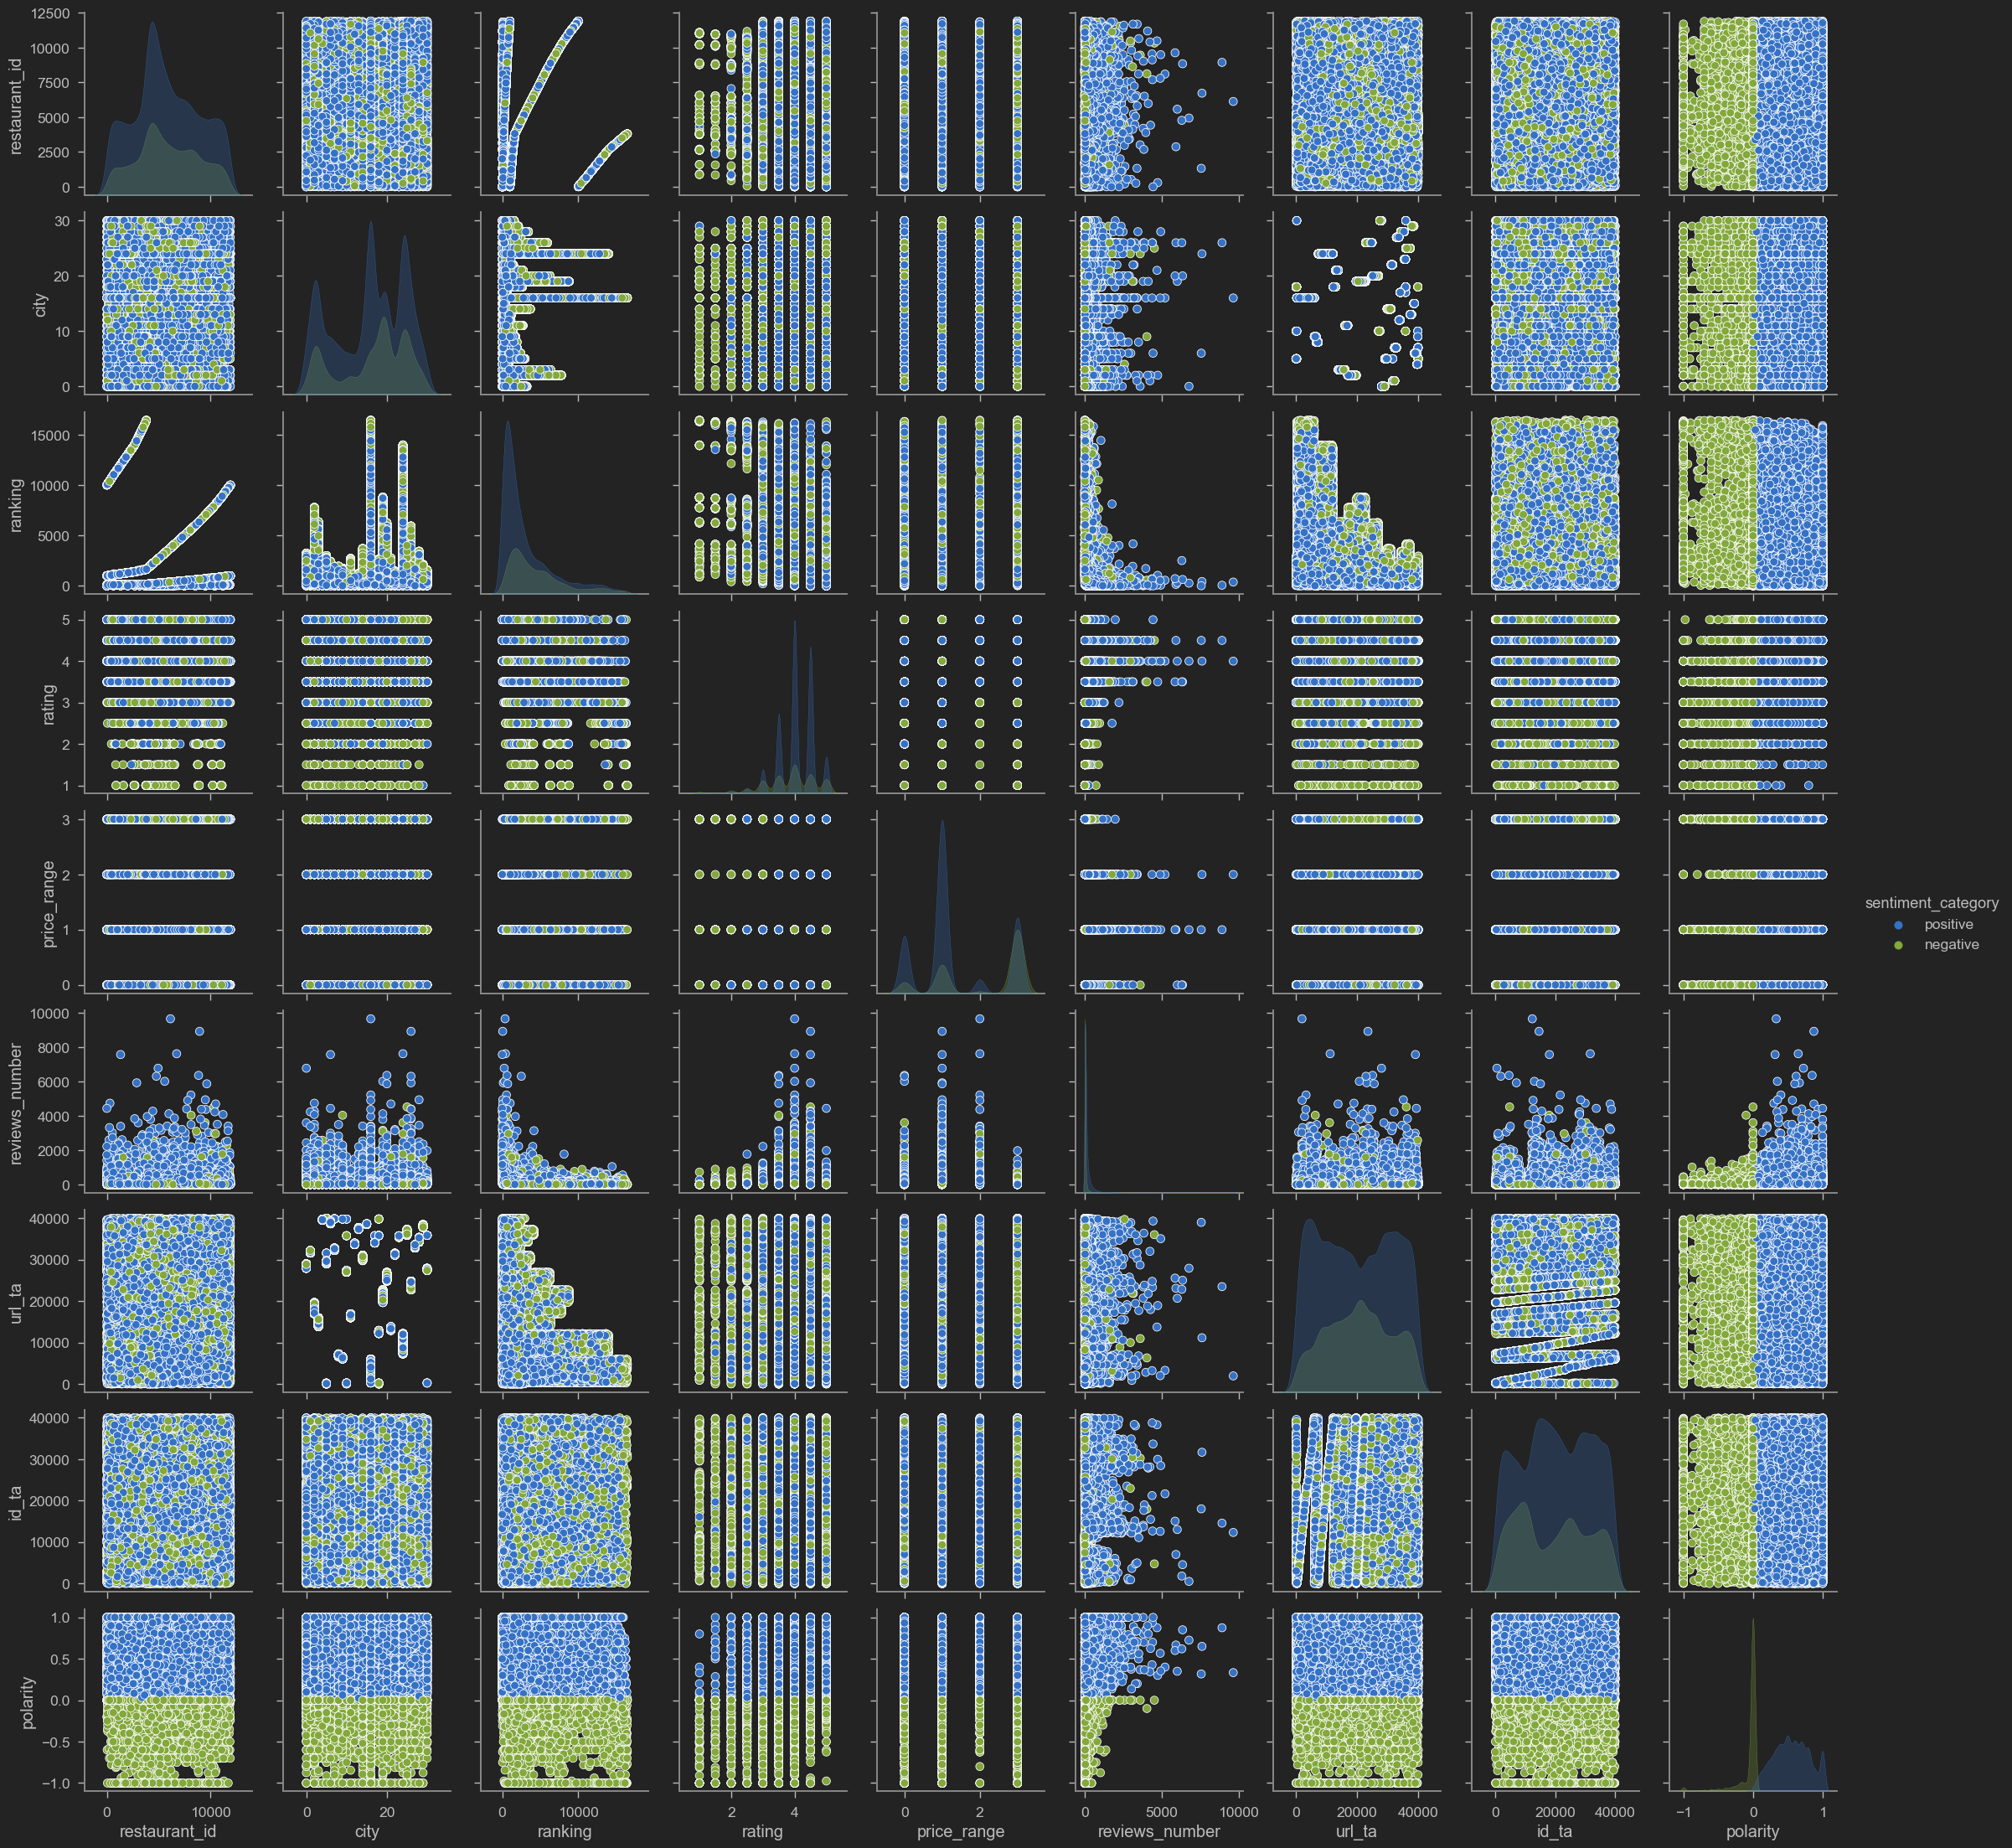

In [21]:
sns.pairplot(df, hue='sentiment_category')

<Axes: >

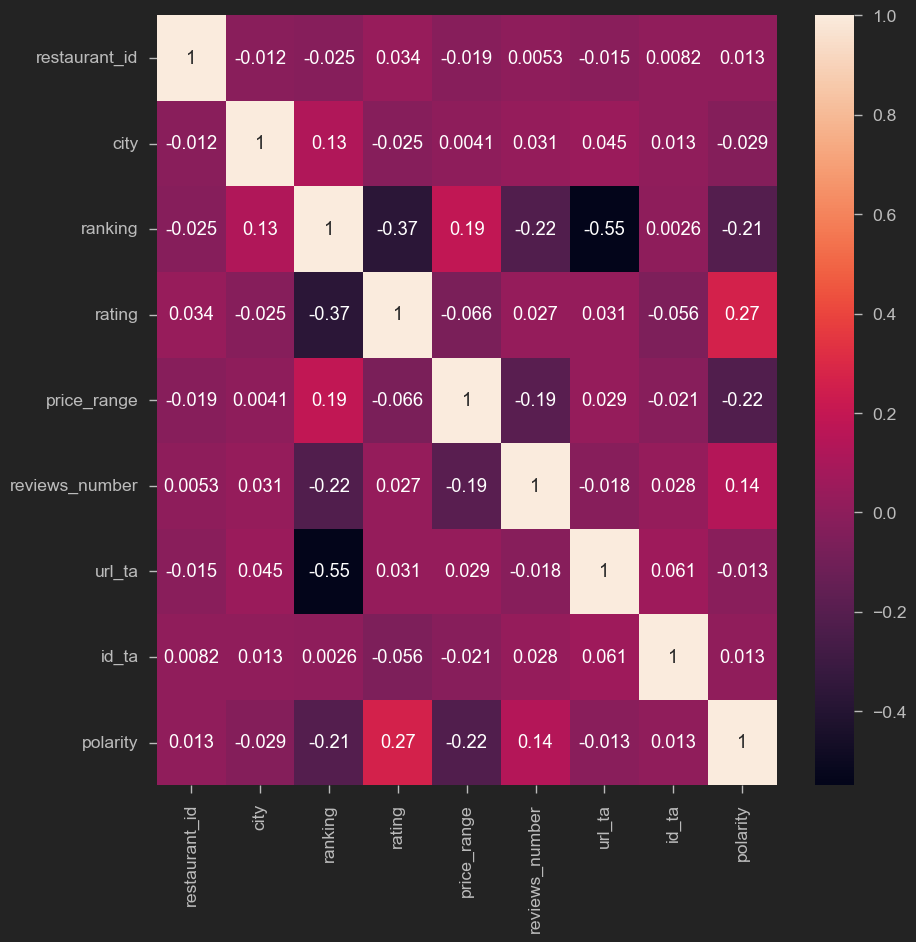

In [22]:
df_num = df.drop(columns=['cuisine_style', 'reviews', 'rew_text', 'dates', 'sentiment_category'])
corr_matrix = df_num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, )

In [23]:
def transform_categories(categories_str):
    categories_list = ast.literal_eval(categories_str)
    
    categories_encoded = pd.Series({category: 1 for category in categories_list if category != 'None'})
    return categories_encoded

df_encoded = df['cuisine_style'].apply(lambda x: transform_categories(x))
df_encoded.replace(np.nan, 0, inplace=True)
df = pd.concat([df, df_encoded], axis=1)

In [24]:
df['dates'].replace("None", "['01/01/1970', '01/01/1970']", inplace=True)

In [25]:
df['dates'] = df['dates'].str.strip("[]").str.replace("'", "")
df['sp_dates'] = df['dates'].str.split(', ')

for i in range(len(df['sp_dates'])):
    df['sp_dates'][i] = [pd.to_datetime(date, format='%m/%d/%Y') for date in df['sp_dates'][i]]

In [26]:
def avg_days(x):
    av=0
    for i in x:
        
        av += (datetime.now() - i).days 
    av /= len(x)
    return av

df['avg_days'] = df['sp_dates'].apply(lambda x: avg_days(x))

In [27]:
df_to_model = df.drop(columns=['cuisine_style', 'reviews', 'rew_text', 'dates', 'sentiment_category', 'sp_dates'])
df_to_model.head()

restaurant_id  city  ranking  rating  price_range  reviews_number  url_ta  \
0           8079    24   5570.0     3.5            1           194.0    8774   
1           3319    27   1537.0     4.0            3            10.0   33483   
2           5882    16    353.0     4.5            2           688.0    5661   
3           5814     3   3458.0     5.0            3             3.0   14532   
4           8685    21    621.0     4.0            1            84.0   13561   

   id_ta  polarity  European  French  International  Unknown  Japanese  Sushi  \
0  13612  0.700000       1.0     1.0            1.0      0.0       0.0    0.0   
1  33942  0.687500       0.0     0.0            0.0      1.0       0.0    0.0   
2  36805 -0.333333       0.0     0.0            0.0      0.0       1.0    1.0   
3  12047  0.000000       0.0     0.0            0.0      1.0       0.0    0.0   
4  28167  0.800000       0.0     0.0            0.0      0.0       0.0    0.0   

   Asian  Grill  Vegetarian Friendly  Vegan Options  Gluten Free Options  \
0    0.0    0.0                  0.0            0.0                  0.0   
1    0.0    0.0                  0.0            0.0                  0.0   
2    1.0    1.0                  1.0            1.0                  1.0   
3    0.0    0.0                  0.0            0.0                  0.0   
4    0.0    0.0                  1.0            0.0                  0.0   

   German  Central European  Italian  Pizza  Fast Food  ...  Cambodian  \
0     0.0               0.0      0.0    0.0        0.0  ...        0.0   
1     0.0               0.0      0.0    0.0        0.0  ...        0.0   
2     0.0               0.0      0.0    0.0        0.0  ...        0.0   
3     0.0               0.0      0.0    0.0        0.0  ...        0.0   
4     1.0               1.0      0.0    0.0        0.0  ...        0.0   

   Albanian  New Zealand  Croatian  Central Asian  Filipino  Tunisian  \
0       0.0          0.0       0.0            0.0       0.0       0.0   
1       0.0          0.0       0.0            0.0       0.0       0.0   
2       0.0          0.0       0.0            0.0       0.0       0.0   
3       0.0          0.0       0.0            0.0       0.0       0.0   
4       0.0          0.0       0.0            0.0       0.0       0.0   

   Cajun & Creole  Romanian  Georgian  Polynesian  Azerbaijani  Caucasian  \
0             0.0       0.0       0.0         0.0          0.0        0.0   
1             0.0       0.0       0.0         0.0          0.0        0.0   
2             0.0       0.0       0.0         0.0          0.0        0.0   
3             0.0       0.0       0.0         0.0          0.0        0.0   
4             0.0       0.0       0.0         0.0          0.0        0.0   

   Afghani  Uzbek  Salvadoran  Yunnan  Native American  Canadian  Xinjiang  \
0      0.0    0.0         0.0     0.0              0.0       0.0       0.0   
1      0.0    0.0         0.0     0.0              0.0       0.0       0.0   
2      0.0    0.0         0.0     0.0              0.0       0.0       0.0   
3      0.0    0.0         0.0     0.0              0.0       0.0       0.0   
4      0.0    0.0         0.0     0.0              0.0       0.0       0.0   

   Burmese  Fujian  Welsh  Latvian  avg_days  
0      0.0     0.0    0.0      0.0    1987.5  
1      0.0     0.0    0.0      0.0    2336.0  
2      0.0     0.0    0.0      0.0    1960.0  
3      0.0     0.0    0.0      0.0   19498.0  
4      0.0     0.0    0.0      0.0    2146.0  

[5 rows x 136 columns]

In [28]:
df.describe()

restaurant_id          city       ranking        rating  price_range  \
count    40000.00000  40000.000000  40000.000000  40000.000000  40000.00000   
mean      5818.50245     15.944325   3676.028525      3.993037      1.57290   
std       3101.05067      8.679969   3708.749567      0.668417      1.11936   
min          0.00000      0.000000      1.000000      1.000000      0.00000   
25%       3818.00000      8.000000    973.000000      3.500000      1.00000   
50%       5490.00000     16.000000   2285.000000      4.000000      1.00000   
75%       8225.00000     24.000000   5260.000000      4.500000      3.00000   
max      11908.00000     30.000000  16444.000000      5.000000      3.00000   

       reviews_number        url_ta         id_ta      polarity      European  \
count    40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean       116.889700  19990.144750  19990.392700      0.365874      0.251500   
std        287.729821  11538.546202  11542.293037      0.374769      0.433881   
min          0.000000      0.000000      0.000000     -1.000000      0.000000   
25%          7.000000   9999.750000   9994.750000      0.000000      0.000000   
50%         28.000000  19998.500000  19989.500000      0.400000      0.000000   
75%        105.000000  29979.250000  29987.250000      0.666667      1.000000   
max       9660.000000  39979.000000  39979.000000      1.000000      1.000000   

             French  International       Unknown     Japanese         Sushi  \
count  40000.000000    40000.00000  40000.000000  40000.00000  40000.000000   
mean       0.079750        0.03960      0.232075      0.03660      0.028900   
std        0.270909        0.19502      0.422162      0.18778      0.167528   
min        0.000000        0.00000      0.000000      0.00000      0.000000   
25%        0.000000        0.00000      0.000000      0.00000      0.000000   
50%        0.000000        0.00000      0.000000      0.00000      0.000000   
75%        0.000000        0.00000      0.000000      0.00000      0.000000   
max        1.000000        1.00000      1.000000      1.00000      1.000000   

              Asian         Grill  Vegetarian Friendly  Vegan Options  \
count  40000.000000  40000.000000         40000.000000   40000.000000   
mean       0.075275      0.012250             0.279725       0.112150   
std        0.263838      0.110001             0.448870       0.315555   
min        0.000000      0.000000             0.000000       0.000000   
25%        0.000000      0.000000             0.000000       0.000000   
50%        0.000000      0.000000             0.000000       0.000000   
75%        0.000000      0.000000             1.000000       0.000000   
max        1.000000      1.000000             1.000000       1.000000   

       Gluten Free Options        German  Central European       Italian  \
count         40000.000000  40000.000000      40000.000000  40000.000000   
mean              0.102825      0.016550          0.034825      0.149100   
std               0.303734      0.127579          0.183339      0.356191   
min               0.000000      0.000000          0.000000      0.000000   
25%               0.000000      0.000000          0.000000      0.000000   
50%               0.000000      0.000000          0.000000      0.000000   
75%               0.000000      0.000000          0.000000      0.000000   
max               1.000000      1.000000          1.000000      1.000000   

              Pizza     Fast Food  ...     Cambodian      Albanian  \
count  40000.000000  40000.000000  ...  40000.000000  40000.000000   
mean       0.071225      0.042625  ...      0.000500      0.000200   
std        0.257204      0.202013  ...      0.022355      0.014141   
min        0.000000      0.000000  ...      0.000000      0.000000   
25%        0.000000      0.000000  ...      0.000000      0.000000   
50%        0.000000      0.000000  ...      0.000000      0.000000   
75%        0.000000 

### 4.  Model

### 4.1 Split data into X and y

In [29]:
RANDOM_SEED = 42

In [30]:
X = df_to_model.drop(['rating'], axis=1)
y = df_to_model['rating']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED)

In [32]:
#   BASE MODEL
regr = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)


regr.fit(X_train, y_train)


y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [33]:
# It can be observed that the difference in that real ratings are always multiples of 0.5
# Write a function to round the predicted ratings accordingly
def round_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [34]:
# Round it
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [35]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 

MAE: 0.1918


In [45]:
import xgboost
from  xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [46]:
y_pred = model.predict(X_test)
# Round it
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [47]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 

MAE: 0.17475


As we can see XGBREgressor with n_estimators=1000 produce a little bit better results than RandomForestRegressor with n_estimators=100 but it takes more time to run

<Axes: >

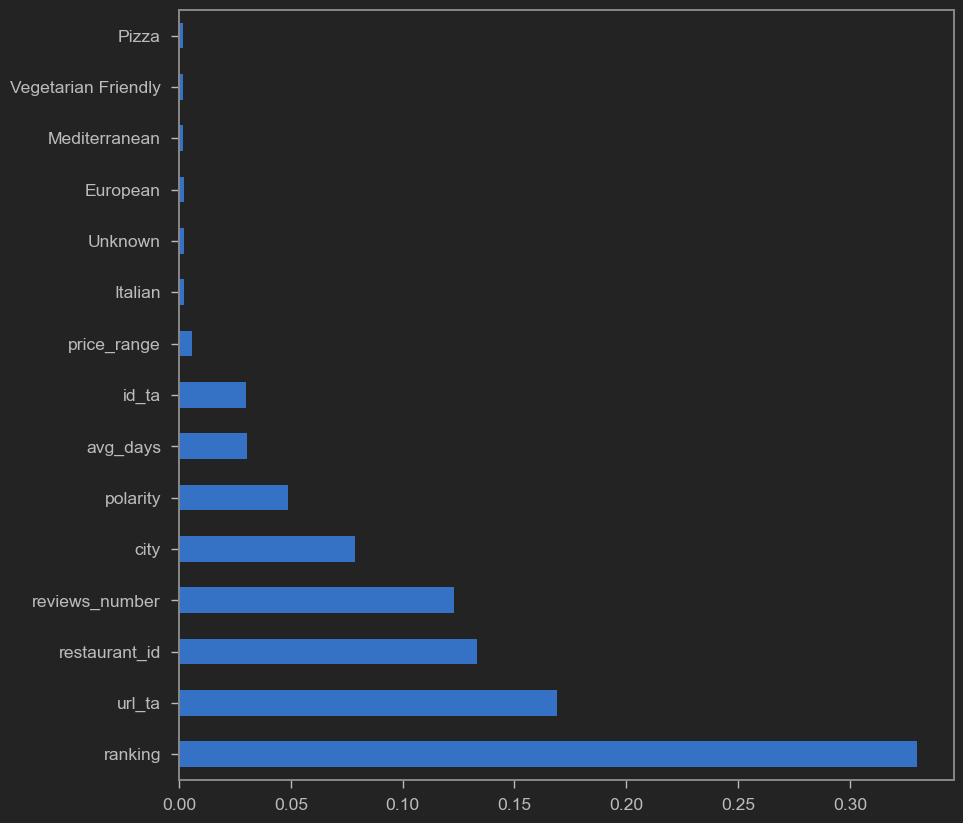

In [48]:
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')